In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

# ========== Input ==========
excel_file = "3.1 etf_with_ark_analysis_clean.xlsx"
sheet_name = "Comparable ETFs"
def get_risk_free_rate():
    irx = yf.Ticker("^IRX")
    rate = irx.history(period="5d")["Close"].dropna()
    if not rate.empty:
        return rate.iloc[-1] / 100 / 12
    else:
        raise ValueError("Unable to get risk free rate")

risk_free_rate = get_risk_free_rate()

# ========== Calculate ==========
def compute_max_drawdown(series):
    cummax = series.cummax()
    drawdown = (series - cummax) / cummax
    return drawdown.min()

def compute_return_to_mdd(returns):
    cumulative = (1 + returns).cumprod()
    mdd = compute_max_drawdown(cumulative)
    total_ret = cumulative.iloc[-1] - 1
    return total_ret / abs(mdd) if mdd != 0 else np.nan

def build_df(series_dict):
    df = pd.concat(series_dict, axis=1)
    df.columns = df.columns.get_level_values(0)  
    df.index.name = "Date"
    return df


# ========== Read ETF list ==========
df_etfs = pd.read_excel(excel_file, sheet_name=sheet_name, engine="openpyxl")
tickers = df_etfs.iloc[:, 0].dropna().astype(str).tolist()
print(f"✅ Get {len(tickers)} ETFs from Excel file.")

# ========== Initial ==========
daily_close_all = {}
sharpe_all = {}
rmd_all = {12: {}, 36: {}, 60: {}}
failed = []

# ========== Main ==========
for ticker in tickers:
    print(f"Handling: {ticker}")
    try:
        data = yf.download(ticker, start="2000-01-01", interval="1d", progress=False)
        close = data["Close"].dropna()
        if close.empty:
            print(f"No data for: {ticker}")
            failed.append(ticker)
            continue

        # Daily close price
        daily_close_all[ticker] = close

        # Monthly return
        monthly_close = close.resample("ME").last()
        returns = monthly_close.pct_change().dropna()

        # Annual Sharpe Ratio
        sharpe = returns.resample("YE").apply(
            lambda r: (r.mean() - risk_free_rate) / r.std() if r.std() > 0 else np.nan
        )
        sharpe_all[ticker] = sharpe

        # Return / Max Drawdown (1Y, 3Y, 5Y)
        for window in [12, 36, 60]:
            if len(returns) >= window:
                rmd = returns.rolling(window).apply(compute_return_to_mdd)
                rmd_all[window][ticker] = rmd
            else:
                rmd_all[window][ticker] = pd.Series(dtype=float)

        print(f"Finished: {ticker}{len(close)} ")

    except Exception as e:
        print(f"Error {ticker}: {e}")
        failed.append(ticker)

# ========== DataFrames ==========
df_close = build_df(daily_close_all)
df_sharpe = build_df(sharpe_all)
df_rmd_1y = build_df(rmd_all[12])
df_rmd_3y = build_df(rmd_all[36])
df_rmd_5y = build_df(rmd_all[60])

# ========== Write Excel ==========
print("\n📤 Writing Excel...")

df_close.reset_index().to_excel("4.1 daily_close.xlsx", index=False)
print("daily_close.xlsx Saved")

df_sharpe.reset_index().to_excel("4.2 sharpe_ratio.xlsx", index=False)
print("sharpe_ratio.xlsx Saved")

with pd.ExcelWriter("4.3 return_mdd.xlsx", engine="openpyxl") as writer:
    df_rmd_1y.reset_index().to_excel(writer, sheet_name="Return-MDD (1Y)", index=False)
    df_rmd_3y.reset_index().to_excel(writer, sheet_name="Return-MDD (3Y)", index=False)
    df_rmd_5y.reset_index().to_excel(writer, sheet_name="Return-MDD (5Y)", index=False)
print("return_mdd.xlsx Saved")

# report errors.
if failed:
    print(f"\nThere are {len(failed)} Ticker error:")
    print(", ".join(failed))
else:
    print("\nAll ETFs are successfully processed! ")


✅ Get 131 ETFs from Excel file.
Handling: ARKK
YF.download() has changed argument auto_adjust default to True
Finished: ARKK2627 
Handling: ARKG
Finished: ARKG2627 
Handling: ARKW
Finished: ARKW2650 
Handling: ARKF
Finished: ARKF1557 
Handling: ARKQ
Finished: ARKQ2650 
Handling: ARKX
Finished: ARKX1015 
Handling: ARKB
Finished: ARKB314 
Handling: IZRL
Finished: IZRL1848 
Handling: PRNT
Finished: PRNT2196 
Handling: ILDR
Finished: ILDR975 
Handling: BUYZ
Finished: BUYZ1288 
Handling: FDIF
Finished: FDIF456 
Handling: EVMT
Finished: EVMT743 
Handling: ARKZ
Finished: ARKZ353 
Handling: DYNI
Finished: DYNI353 
Handling: ARKW
Finished: ARKW2650 
Handling: SYNB
Finished: SYNB635 
Handling: TSLT
Finished: TSLT371 
Handling: WGMI
Finished: WGMI797 
Handling: AIYY
Finished: AIYY344 
Handling: SARK
Finished: SARK859 
Handling: TIME
Finished: TIME804 
Handling: MAGS
Finished: MAGS504 
Handling: CEPI
Finished: CEPI88 
Handling: FDG
Finished: FDG1264 
Handling: BMED
Finished: BMED1136 
Handling: ME

In [2]:
import pandas as pd
import numpy as np

# ========================== Load Data ==========================
df_close = pd.read_excel("4.1 daily_close.xlsx", index_col=0, parse_dates=True)
df_close.index = pd.to_datetime(df_close.index)
df_close = df_close.sort_index()
df_close = df_close.dropna(axis=1, how="all")

if "ARKK" not in df_close.columns:
    raise ValueError("ARKK is not in the daily_close data.")

etfs = [col for col in df_close.columns if col != "ARKK"]
start_date = df_close["ARKK"].dropna().index.min()
df_close = df_close[df_close.index >= start_date]

# ========================== Return Calculation ==========================
daily_ret = df_close.pct_change(fill_method=None)
weekly_ret = df_close.resample("W-FRI").last().pct_change(fill_method=None)
monthly_ret = df_close.resample("M").last().pct_change(fill_method=None)

# ========================== Rolling Correlation Function ==========================
def compute_rolling_correlation(df_ret, window, label):
    result = {}
    for etf in etfs:
        if etf not in df_ret.columns:
            continue
        if df_ret[[etf, "ARKK"]].dropna().shape[0] < window:
            print(f"⚠️ Skipping {etf} ({label}): not enough overlapping data")
            continue
        corr = df_ret["ARKK"].rolling(window).corr(df_ret[etf])
        result[etf] = corr
    df_result = pd.DataFrame(result)
    df_result.index.name = "Date"
    return df_result

# ========================== Rolling Correlation Calculation ==========================
print("📈 Calculating DAILY rolling correlation...")
rolling_corr_daily = compute_rolling_correlation(daily_ret, window=30, label="daily")

print("📈 Calculating WEEKLY rolling correlation...")
rolling_corr_weekly = compute_rolling_correlation(weekly_ret, window=12, label="weekly")

print("📈 Calculating MONTHLY rolling correlation...")
rolling_corr_monthly = compute_rolling_correlation(monthly_ret, window=6, label="monthly")

# ========================== Save to Excel ==========================
print("💾 Saving to 'rolling_correlation_with_ARKK.xlsx'...")
with pd.ExcelWriter("4.4 rolling_correlation_with_ARKK.xlsx", engine="openpyxl") as writer:
    rolling_corr_daily.to_excel(writer, sheet_name="Daily")
    rolling_corr_weekly.to_excel(writer, sheet_name="Weekly")
    rolling_corr_monthly.to_excel(writer, sheet_name="Monthly")

print("✅ Done. File saved as 'rolling_correlation_with_ARKK.xlsx'.")


/var/folders/7g/kq56s8d958b3kd1gdqwgbtzc0000gr/T/ipykernel_80931/647830545.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_ret = df_close.resample("M").last().pct_change(fill_method=None)


📈 Calculating DAILY rolling correlation...
⚠️ Skipping MVLL (daily): not enough overlapping data
⚠️ Skipping MRAL (daily): not enough overlapping data
📈 Calculating WEEKLY rolling correlation...
⚠️ Skipping BEGS (weekly): not enough overlapping data
⚠️ Skipping JXX (weekly): not enough overlapping data
⚠️ Skipping MVLL (weekly): not enough overlapping data
⚠️ Skipping MRAL (weekly): not enough overlapping data
⚠️ Skipping COIW (weekly): not enough overlapping data
📈 Calculating MONTHLY rolling correlation...
⚠️ Skipping CEPI (monthly): not enough overlapping data
⚠️ Skipping WAR (monthly): not enough overlapping data
⚠️ Skipping GROZ (monthly): not enough overlapping data
⚠️ Skipping VOLT (monthly): not enough overlapping data
⚠️ Skipping BEGS (monthly): not enough overlapping data
⚠️ Skipping JXX (monthly): not enough overlapping data
⚠️ Skipping MVLL (monthly): not enough overlapping data
⚠️ Skipping MRAL (monthly): not enough overlapping data
⚠️ Skipping COIW (monthly): not enough o

In [3]:
top_etfs = rolling_corr_daily.mean().sort_values(ascending=False).head(15).index.tolist()
print("Top correlated ETFs with ARKK:\n", top_etfs)


Top correlated ETFs with ARKK:
 ['TARK', 'OARK', 'JXX', 'ARKF', 'ARKW', 'COIW', 'CEPI', 'ARKQ', 'GROZ', 'FFND', 'ARKG', 'BUYZ', 'FDG', 'BKIV', 'ILDR']


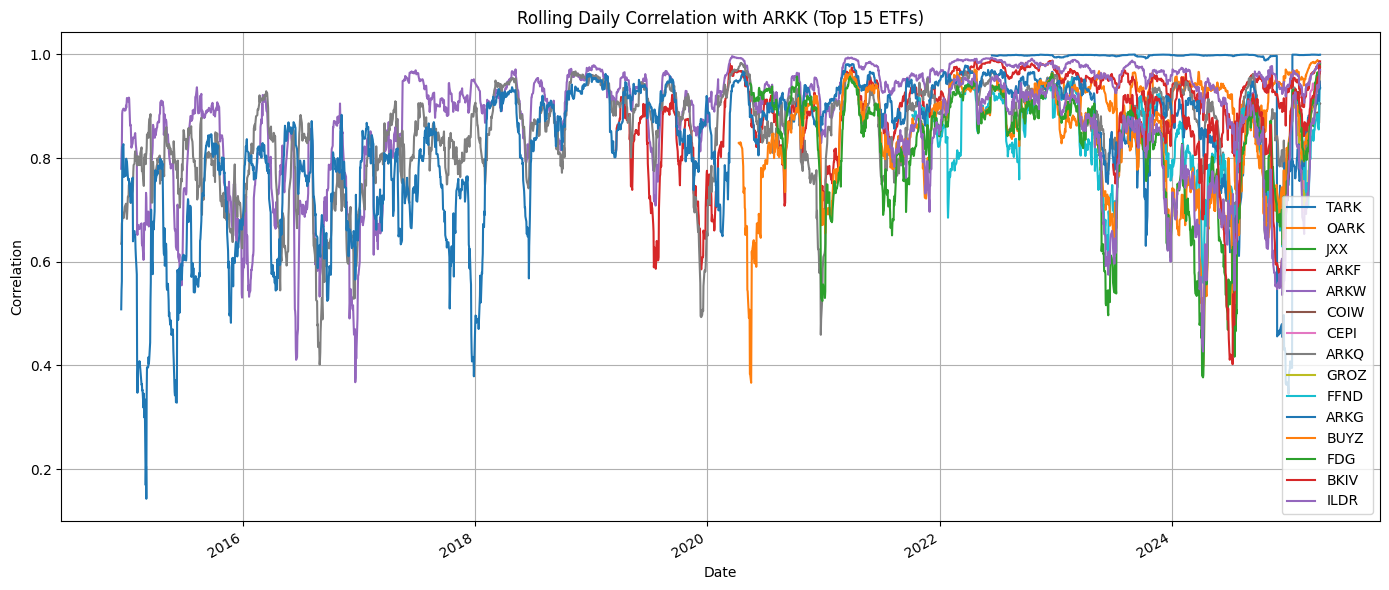

In [4]:
import matplotlib.pyplot as plt

rolling_corr_daily[top_etfs].plot(figsize=(14,6))
plt.title("Rolling Daily Correlation with ARKK (Top 15 ETFs)")
plt.ylabel("Correlation")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()
